In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import dotenv
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from ivae_scorer.utils import set_all_seeds

project_path = Path(dotenv.find_dotenv()).parent
results_path = project_path.joinpath("results")
data_path = project_path.joinpath("data")
figs_path = results_path.joinpath("figs")
tables_path = results_path.joinpath("tables")

set_all_seeds(seed=42)

tf.config.experimental.enable_op_determinism()

2024-09-06 11:59:38.288404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
config = dotenv.dotenv_values()
frac_list = np.arange(
    float(config["FRAC_START"]), float(config["FRAC_STOP"]), float(config["FRAC_STEP"])
)
frac_list

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

In [3]:
models = ["ivae_kegg", "ivae_reactome"] + [
    f"ivae_random-{frac:.1f}" for frac in frac_list
]

In [4]:
# Metrics

metric_scores = [
    pd.read_pickle(results_path.joinpath(m, "scores_metrics.pkl")) for m in models
]
metric_scores = pd.concat(metric_scores, axis=0, ignore_index=True)
metric_scores = metric_scores
metric_scores.head()

,seed,metric,split,score,model
0,0,loss,train,2.099017,ivae_kegg
1,0,mse,train,0.000771,ivae_kegg
2,0,loss,val,2.101533,ivae_kegg
3,0,mse,val,0.000773,ivae_kegg
4,0,loss,test,2.113942,ivae_kegg


In [5]:
# clustering

clustering_scores = [
    pd.read_pickle(results_path.joinpath(m, "scores_clustering.pkl")) for m in models
]
clustering_scores = pd.concat(clustering_scores, axis=0, ignore_index=True)
clustering_scores.head()

,split,layer,score,model
0,train,1,0.606398,ivae_kegg
1,train,1,0.641018,ivae_kegg
2,train,1,0.706496,ivae_kegg
3,train,1,0.629728,ivae_kegg
4,train,1,0.591613,ivae_kegg


In [6]:
clustering_scores.groupby(["model", "layer"]).size()

model            layer
ivae_kegg        1        300
                 2        300
ivae_random-0.1  1        300
ivae_random-0.2  1        300
ivae_random-0.3  1        300
ivae_random-0.4  1        300
ivae_random-0.5  1        300
ivae_random-0.6  1        300
ivae_random-0.7  1        300
ivae_random-0.8  1        300
ivae_reactome    1        300
dtype: int64

In [7]:
# informed

informed_scores = [
    pd.read_pickle(results_path.joinpath(m, "scores_informed.pkl")) for m in models
]
informed_scores = pd.concat(informed_scores, axis=0, ignore_index=True)
informed_scores.head()

,split,layer,score,model
0,train,1,0.823246,ivae_kegg
1,train,1,0.816320,ivae_kegg
2,train,1,0.820593,ivae_kegg
3,train,1,0.819062,ivae_kegg
4,train,1,0.826054,ivae_kegg


In [8]:
informed_scores.head()

,split,layer,score,model
0,train,1,0.823246,ivae_kegg
1,train,1,0.816320,ivae_kegg
2,train,1,0.820593,ivae_kegg
3,train,1,0.819062,ivae_kegg
4,train,1,0.826054,ivae_kegg


In [9]:
clustering_scores["kind"] = "clustering"
informed_scores["kind"] = "informed"

In [10]:
metric_scores_filt = metric_scores.rename(columns={"metric": "kind"}).query(
    "split=='test' & kind=='mse'"
)[["score", "model", "kind"]]

In [11]:
scores = (
    pd.concat((clustering_scores, informed_scores), axis=0, ignore_index=True)
    .query("layer==1 & split=='test'")
    .drop(["layer", "split"], axis=1)
)
scores = pd.concat((scores, metric_scores_filt), axis=0, ignore_index=True)
scores.head()

,score,model,kind
0,0.603190,ivae_kegg,clustering
1,0.628369,ivae_kegg,clustering
2,0.700615,ivae_kegg,clustering
3,0.623551,ivae_kegg,clustering
4,0.587372,ivae_kegg,clustering


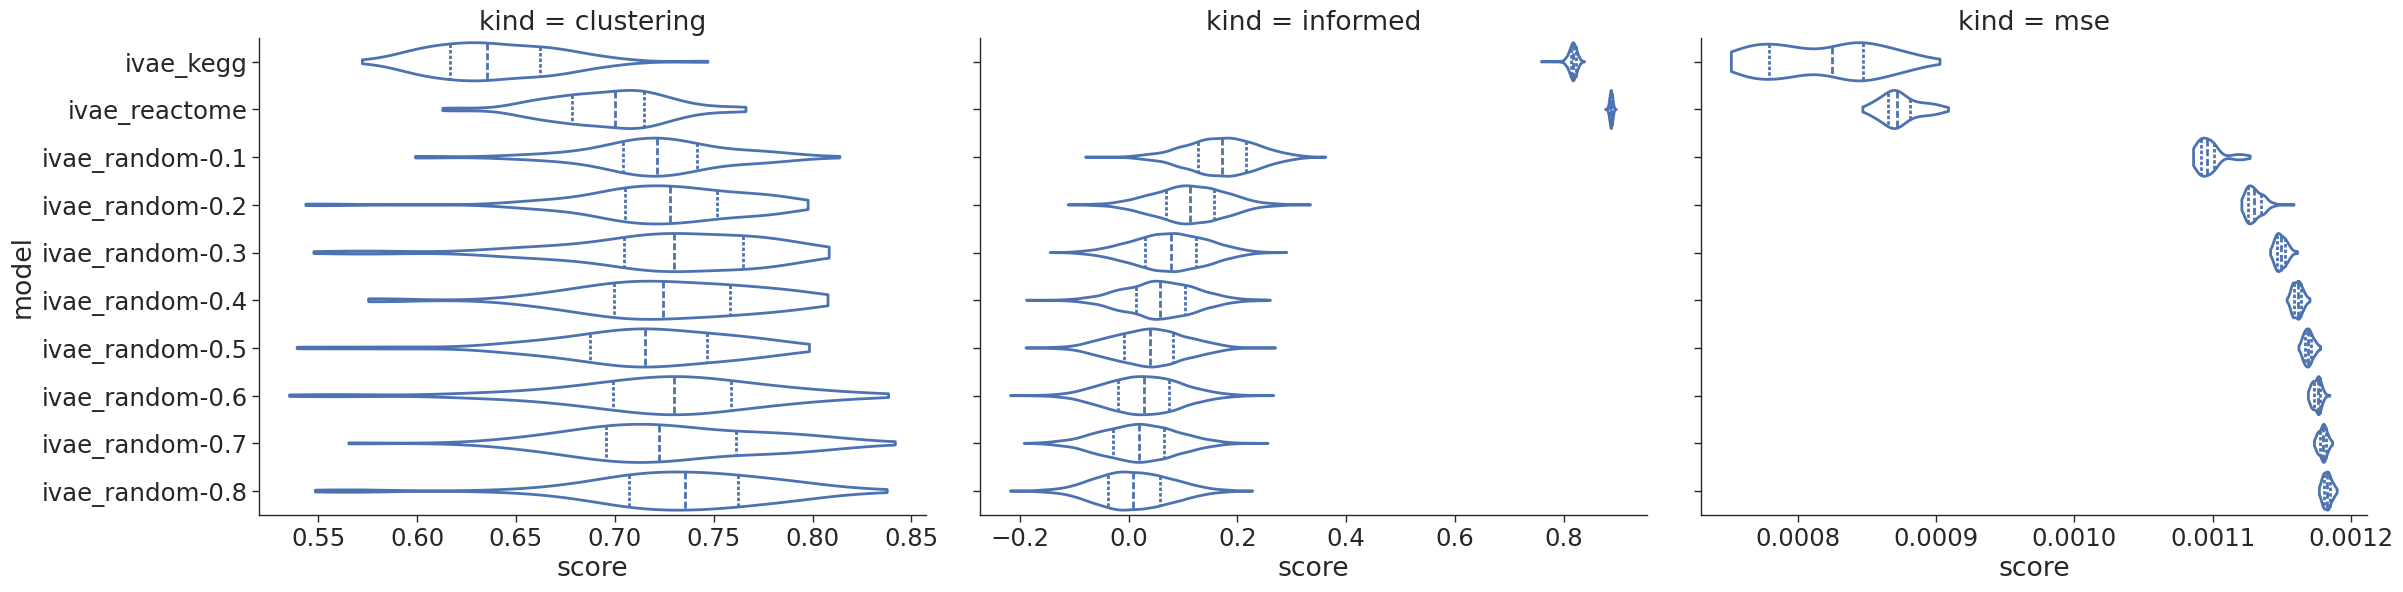

In [12]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=2, style="ticks", rc=custom_params)
fac = 0.7

g = sns.catplot(
    data=scores,
    kind="violin",
    col="kind",
    height=9 * fac,
    aspect=16 / 9 * fac,
    sharey=True,
    sharex=False,
    y="model",
    x="score",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=2,
    legend_out=False,
    col_wrap=4,
)

In [13]:
informed_scores.groupby(["model", "kind", "split", "layer"]).describe()

score                                \
                                       count      mean       std       min   
model           kind     split layer                                         
ivae_kegg       informed test  1      4950.0  0.817058  0.007758  0.759153   
                               2      4950.0  0.538705  0.081254  0.198870   
                         train 1      4950.0  0.817205  0.007848  0.759626   
                               2      4950.0  0.536786  0.081407  0.189745   
                         val   1      4950.0  0.816569  0.007890  0.758540   
                               2      4950.0  0.537154  0.081734  0.192672   
ivae_random-0.1 informed test  1      4950.0  0.170112  0.063927 -0.079319   
                         train 1      4950.0  0.171190  0.064050 -0.072942   
                         val   1      4950.0  0.170857  0.063939 -0.073056   
ivae_random-0.2 informed test  1      4950.0  0.112700  0.065224 -0.111299   
                         train 1      4950.0  0.112720  0.065485 -0.113699   
                         val   1      4950.0  0.112555  0.065235 -0.112378   
ivae_random-0.3 informed test  1      4950.0  0.076146  0.067113 -0.144471   
                         train 1      4950.0  0.077653  0.067123 -0.149408   
                         val   1      4950.0  0.077037  0.066959 -0.158335   
ivae_random-0.4 informed test  1      4950.0  0.058100  0.065807 -0.187865   
                         train 1      4950.0  0.058613  0.065862 -0.183011   
                         val   1      4950.0  0.058439  0.065844 -0.191242   
ivae_random-0.5 informed test  1      4950.0  0.037512  0.066350 -0.188906   
                         train 1      4950.0  0.037094  0.066605 -0.170140   
                         val   1      4950.0  0.037020  0.066533 -0.178305   
ivae_random-0.6 informed test  1      4950.0  0.027429  0.067954 -0.217321   
                         train 1      4950.0  0.027896  0.067572 -0.215107   
                         val   1      4950.0  0.027853  0.068169 -0.209692   
ivae_random-0.7 informed test  1      4950.0  0.018605  0.068037 -0.191965   
                         train 1      4950.0  0.018378  0.067588 -0.196446   
                         val   1      4950.0  0.018429  0.067831 -0.182755   
ivae_random-0.8 informed test  1      4950.0  0.009459  0.068104 -0.217508   
                         train 1      4950.0  0.009198  0.068047 -0.209166   
                         val   1      4950.0  0.009341  0.067705 -0.214958   
ivae_reactome   informed test  1      4950.0  0.887835  0.002746  0.877257   
                         train 1      4950.0  0.888194  0.002723  0.877832   
                         val   1      4950.0  0.887967  0.002729  0.877611   

                                                                              
                                           25%       50%       75%       max  
model           kind     split layer                                          
ivae_kegg       informed test  1      0.812791  0.817631  0.822145  0.838730  
                               2      0.488912  0.546976  0.596996  0.746969  
                         train 1      0.812949  0.817817  0.822272  0.838844  
                               2      0.486487  0.544928  0.594969  0.746630  
                         val   1      0.812287  0.817170  0.821711  0.838540  
                               2      0.486160  0.545722  0.596119  0.747774  
ivae_random-0.1 informed test  1      0.126890  0.172059  0.214974  0.362681  
                         train 1      0.129415  0.172658  0.215894  0.369512  
                         val   1      0.128275  0.172420  0.215350  0.376422  
ivae_random-0.2 informed test  1      0.069234  0.112789  0.157591  0.334718  
                         train 1      0.068409  0.112841  0.157957  0.341462  
                         val   1      0.068969  0.113282  0.158325  0.327394  
ivae_random-0.3 informed test  1      0.03051